# 1. 导入python库

In [1]:
import pandas as pd
import numpy as np
import os

%matplotlib inline
from matplotlib import pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix, roc_curve, auc, recall_score, precision_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping


# 2. 参数设置

In [2]:
daily_back=20

batch_size=32
epochs=100
patience=15

LSTM_num=100
dense_num=20

pop_size = 1
max_iter = 2

mix_file='daily_data.xlsx'
first_columns='search_index'


total_day=2338 #根据查看沪深300数据表，得到数值
train_num=1870
# total_day=2159 #根据查看上证指数数据表，得到数值
# train_num=1295
test_num=total_day-train_num

# 3. 读取原始数据

In [3]:
new_dir='/Users/ccmac/Desktop/完成SCI数据'


daily_df=pd.read_excel(os.path.join(new_dir,mix_file))
fif_df=pd.read_excel(os.path.join(new_dir,'fif_data.xlsx'))
target_df=pd.read_excel(os.path.join(new_dir,'target.xlsx'))


# 4. 标准化

## 4.1 历史数据标准化函数norm

In [4]:
def normalize_data(df):
    """对DataFrame的指定列进行标准化处理（Z-score标准化）"""
    # 复制数据以避免修改原始数据
    normalized_df = df.copy()
    
    # 需要标准化的列名
    columns_to_normalize = ['open', 'high', 'low', 'close', 'volume_rate']
    
    # 循环处理每一列，避免重复代码
    for col in columns_to_normalize:
        mean_val = df[col].mean()
        std_val = df[col].std()
        # 防止标准差为0导致除零错误
        if std_val != 0:
            normalized_df[col] = (df[col] - mean_val) / std_val
    
    return normalized_df

# 5. 数据切分训练集与测试集

## 5.1 数据切分函数

In [5]:
def split_and_normalize_data(train_num=train_num):
    """拆分数据并对训练集和测试集进行标准化处理"""
    # 拆分每日数据
    daily_train = daily_df.loc[daily_df.index < train_num]
    daily_test = daily_df.loc[daily_df.index >= train_num]
    
    # 拆分fif数据（16倍关系）
    fif_threshold = 16 * train_num
    fif_train = fif_df.loc[fif_df.index < fif_threshold]
    fif_test = fif_df.loc[fif_df.index >= fif_threshold]
    
    # 拆分目标数据
    target_train = target_df.loc[target_df.index < train_num]
    target_test = target_df.loc[target_df.index >= train_num]
    
    # 对各数据集进行标准化
    daily_train_norm = normalize_data(daily_train)
    daily_test_norm = normalize_data(daily_test)
    fif_train_norm = normalize_data(fif_train)
    fif_test_norm = normalize_data(fif_test)
    
    # 返回包含所有数据集的字典
    return {
        'daily_train_df': daily_train_norm,
        'daily_test_df': daily_test_norm,
        'fif_train_df': fif_train_norm,
        'fif_test_df': fif_test_norm,
        'target_train_df': target_train,
        'target_test_df': target_test
    }

## 5.2 进行数据切分

In [6]:
# 一次调用并解包结果
data = split_and_normalize_data()
daily_norm_train_df, daily_norm_test_df, fif_norm_train_df, fif_norm_test_df, target_norm_train_df, target_norm_test_df = \
    data['daily_train_df'], data['daily_test_df'], data['fif_train_df'], data['fif_test_df'], data['target_train_df'], data['target_test_df']

# 打印各数据集形状
print('日频训练切分：', daily_norm_train_df.shape)
print('日频测试切分：', daily_norm_test_df.shape)
print('十五分钟频训练切分：', fif_norm_train_df.shape)
print('十五分钟频测试切分：', fif_norm_test_df.shape)
print('训练目标切分：', target_norm_train_df.shape)
print('测试目标切分：', target_norm_test_df.shape)


日频训练切分： (1870, 6)
日频测试切分： (468, 6)
十五分钟频训练切分： (29920, 6)
十五分钟频测试切分： (7488, 6)
训练目标切分： (1870, 2)
测试目标切分： (468, 2)


# 6. 数据转化为神经网络输入格式

## 6.1 建立转化类（返回多个字典）

In [7]:
class Data_maker:
    def __init__(self,train_num,test_num,fif_back,daily_back):
        self.train_num=train_num
        self.test_num=test_num
        self.fif_back=fif_back
        self.daily_back=daily_back
       


    def daily_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.daily_back)) #总共1650个数据，由于扣除前面20个数据，所以为1630
            ### 先构造空（预测日长度*日后移）array
            samples = np.zeros((len(rows),
                                 self.daily_back,
                                 5))
            print(samples.shape)
            for j in rows:
                ### 每一个填入用于预测一天的开盘价到波动率矩阵
                samples[j] = data.loc[
                                  (data.index >= j) & (data.index < self.daily_back + j),
                                  'open':'volume_rate']
            print(data.index)
            print('日频训练array：',samples.shape)
            return samples
    def fif_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.daily_back))
            samples = np.zeros((len(rows),
                                 self.fif_back,
                                 5))
            for j in rows:

                samples[j] = data.loc[
                              (data.index >= j * self.fif_back ) & (data.index < (j+1) * self.fif_back),
                              'open':]
            print('十五分钟训练array：',samples.shape)
            return samples

   

    def daily_test_data(self,data):
        while True:
            rows = list(range(self.test_num - self.daily_back))
            print(self.test_num,self.daily_back)
            print(rows)
            samples = np.zeros((len(rows),
                                self.daily_back,
                                 5))
            for j in rows:


                samples[j] = data.loc[
                                  (data.index >= self.train_num+j) & (data.index < self.train_num+self.daily_back + j),
                                  'open':'volume_rate']
            print('日测试array：',samples.shape)
            print('试一试index', data.index,'train_num',self.train_num)
            return samples


   
    def fif_test_data(self,data):
        while True:
            rows = list(range(self.test_num - self.daily_back))
            samples = np.zeros((len(rows),
                                self.fif_back,
                                 5))
            for j in rows:


                samples[j] = data.loc[
                                 (data.index >= 16*self.train_num+(j) * self.fif_back) & (data.index < 16*self.train_num+(j+1) * self.fif_back),
                                 'open':]
            print('十五分钟测试array：',samples.shape)
            return samples
    def target_train_data(self,data):
        while True:
            rows = list(range(self.train_num-self.daily_back))
            targets = np.zeros((len(rows),))
            for j in rows:


                targets[j] = data.loc[data.index == j, 'target'].iloc[0] #根据提示，添加了.iloc[0]
            print('训练标签array',targets.shape)
            return targets
    def target_test_data(self,data):
        while True:
            rows = list(range(self.test_num-self.daily_back))
            targets = np.zeros((len(rows),))
            for j in rows:


                targets[j] = data.loc[data.index == self.train_num+j, 'target'].iloc[0] ##出问题：应该是。而不是***：data.index == self.train_num+j
            print(targets.shape)
            return targets

## 6.2 设置类方法里的参数，赋值给origin_data_maker，仍然是一个class类

In [8]:
origin_data_maker=Data_maker(train_num=train_num,test_num=test_num,fif_back=16,daily_back=20)

# 6.3 调用类中的方法,处理原始数据

In [9]:
DM = origin_data_maker

daily_train_prepared = DM.daily_train_data(daily_norm_train_df)
daily_test_prepared = DM.daily_test_data(daily_norm_test_df)

fif_train_prepared = DM.fif_train_data(fif_norm_train_df)
fif_test_prepared = DM.fif_test_data(fif_norm_test_df)

target_train_prepared = DM.target_train_data(target_norm_train_df)
target_test_prepared = DM.target_test_data(target_norm_test_df)


(1850, 20, 5)
Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869],
      dtype='int64', length=1870)
日频训练array： (1850, 20, 5)
468 20
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176

# 7. 神经网络模型训练

## 7.1 模型建立 

In [10]:
def my_model(daily_back, LSTM_num):

    # 日频输入
    daily_input = Input(shape=(daily_back, 5), dtype='float32', name='daily_input')
    
    LSTM_daily = layers.LSTM(LSTM_num)(daily_input)
    
    # 合并与全连接
  
    # alloy = layers.Dense(dense_num, activation='relu')(LSTM_daily)
    # dropout = layers.Dropout(0.2)(alloy)
    output = layers.Dense(1, activation='sigmoid')(LSTM_daily)
    
    model = Model(daily_input, output)
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['acc'])
    return model

In [11]:
# 创建早停回调
early_stopping = EarlyStopping(
    monitor='val_acc',    # 监控验证集损失
    patience=patience,           # 如果连续10个epoch验证集损失没有改善，则停止训练
    restore_best_weights=True  # 恢复验证集损失最低时的模型权重
)


In [12]:
## 定义适应函数

In [13]:
import numpy as np

def fitness_function(params):
    LSTM_num = int(params[0])
    
    


    
    model = my_model(daily_back=daily_back,  # 替换为实际daily_back值
                     LSTM_num=LSTM_num,
                     )
    
    history = model.fit(x=daily_train_prepared,y=target_train_prepared,batch_size=batch_size,
                validation_split=0.25,epochs=epochs,callbacks=[early_stopping])
    return history.history['val_loss'][-1]  # 返回验证损失（越小越好）

In [14]:
# 实现麻雀算法

In [15]:
def sparrow(pop_size, max_iter, dim, lower_bounds, upper_bounds, fitness_func):
    pop = np.random.uniform(low=lower_bounds, high=upper_bounds, size=(pop_size, dim))
    fitness = np.array([fitness_func(ind) for ind in pop])
    best_idx = np.argmin(fitness)
    best_sol = pop[best_idx].copy()
    best_fit = fitness[best_idx]

    for t in range(max_iter):
        # 排序
        sorted_idx = np.argsort(fitness)
        pop = pop[sorted_idx]
        fitness = fitness[sorted_idx]

        # 发现者策略
        for i in range(int(pop_size * 0.2)):
            if np.random.rand() < 0.8:
                pop[i] *= np.exp(-i / (np.random.rand() * max_iter))
            else:
                pop[i] += np.random.normal(0, 1)
            
            # 每次更新后立即检查边界
            pop[i] = np.clip(pop[i], lower_bounds, upper_bounds)

        # 跟随者策略 - 改进矩阵计算
        for i in range(int(pop_size * 0.2), pop_size):
            if i > pop_size / 2:
                pop[i] = np.random.normal(0, 1) * np.exp((pop[-1] - pop[i]) / (i ** 2))
            else:
                # 简化矩阵计算，避免奇异矩阵问题
                A = np.random.choice([-1, 1], size=dim)
                pop[i] = pop[0] + A * (pop[0] - pop[i])
            
            # 每次更新后立即检查边界
            pop[i] = np.clip(pop[i], lower_bounds, upper_bounds)

        # 警戒者策略
        for i in range(pop_size):
            if fitness[i] > best_fit:
                pop[i] = best_sol + np.random.normal(0, 1)
                # 立即检查边界
                pop[i] = np.clip(pop[i], lower_bounds, upper_bounds)

        # 更新最佳解
        fitness = np.array([fitness_func(ind) for ind in pop])
        current_best_idx = np.argmin(fitness)
        if fitness[current_best_idx] < best_fit:
            best_fit = fitness[current_best_idx]
            best_sol = pop[current_best_idx].copy()

    return best_sol, best_fit

In [16]:
# 运行优化并训练最终模型


In [17]:
# 超参数范围（LSTM_num, dense_num）
lower_bounds = [64]
upper_bounds = [256]
pop_size = pop_size
max_iter = max_iter

best_params, best_fitness =sparrow(pop_size, max_iter, 1, lower_bounds, upper_bounds, fitness_function)

print(f"最佳参数：LSTM_num={int(best_params[0])}")
print(f"最佳验证准确率：{best_fitness}")


# 用最佳参数训练最终模型
final_model = my_model(daily_back=daily_back,  # 替换为实际值
                       LSTM_num=int(best_params[0]),
                       )
history=final_model.fit(x=daily_train_prepared,y=target_train_prepared,batch_size=batch_size,
                validation_split=0.25,epochs=epochs,callbacks=[early_stopping])

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.5385 - loss: 0.7002 - val_acc: 0.4730 - val_loss: 0.6969
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.5135 - loss: 0.6923 - val_acc: 0.4773 - val_loss: 0.6984
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.5325 - loss: 0.6905 - val_acc: 0.4687 - val_loss: 0.7005
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.5464 - loss: 0.6830 - val_acc: 0.4644 - val_loss: 0.7013
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.5599 - loss: 0.6887 - val_acc: 0.4730 - val_loss: 0.7040
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.5488 - loss: 0.6876 - val_acc: 0.4730 - val_loss: 0.6989
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.5281 - loss: 0.6912 - val_acc: 0.4838 - val_loss: 0.7040
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.5503 - loss: 0.6841 - val_acc: 0.4622 - val_loss: 0.7031
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.5510

## 7.3 添加输出模型参数的代码块

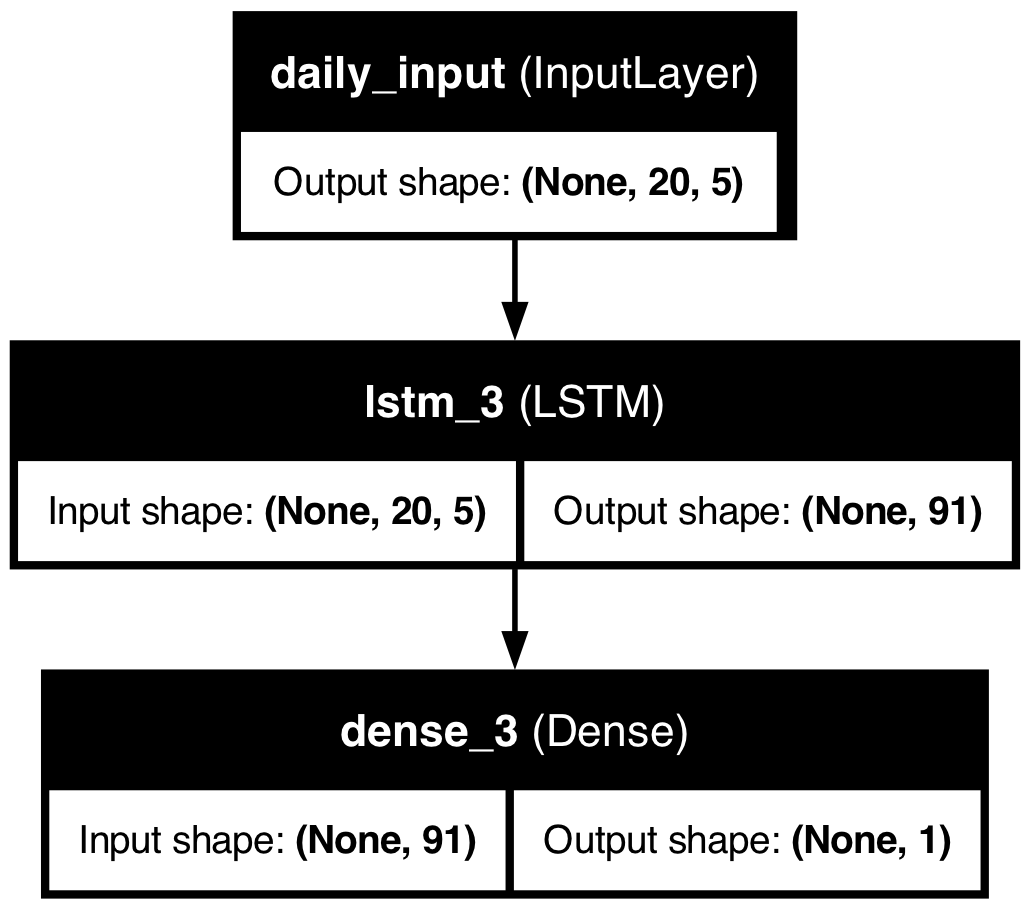

In [18]:
plot_model(final_model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

## 7.5 model.evaluate(输入测试数据)，进行模型预测性能测试

In [19]:
loss,accuracy = final_model.evaluate(daily_test_prepared,y=target_test_prepared)
print(loss,accuracy)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5583 - loss: 0.6915 
0.6915501952171326 0.546875


# 8. 回测

# 构建y的函数

In [20]:
def gen_y_pred():
    y_predict=model.predict(daily_test_prepared,batch_size=1).reshape(test_num-daily_back).tolist() ###batch_size要设为1，不然evaluate和predict结果不同
    y_pred=[]
    for i,v in enumerate(y_predict):
        if v>0.5:
            y_pred.append(1)
        if v<0.5:
            y_pred.append(0)
    return y_pred

# 制作y

In [21]:
# 1. 获取测试集的预测概率（0-1之间）
y_pred_proba = final_model.predict( daily_test_prepared)

# 2. 将概率转换为类别标签（默认以0.5为阈值，可根据需求调整）
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int).flatten().tolist()  # 转换为0/1的一维数组
print("y_pred:", y_pred)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
y_pred: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [22]:
def get_backtest_data(daily_df, train_num, daily_back):
    """直接获取最终回测数据：索引 >= train_num + daily_back 的开盘价和收盘价"""
    return daily_df.loc[
        daily_df.index >= train_num + daily_back,
        ['open', 'close']
    ]

# 使用示例
backtrader_df = get_backtest_data(daily_df, train_num, daily_back)


# 形成day_rate_of_return日内收益率，和rate_of_return隔夜收益率

In [23]:
# 计算收益率
backtrader_df['rate_of_return'] = backtrader_df['close'].rolling(2).apply(lambda x: x[1] / x[0] - 1, raw=True)
backtrader_df['day_rate_of_return'] = backtrader_df['close'] / backtrader_df['open'] - 1

# 将前一天的收盘价作为last_close，这样长度会自动匹配
backtrader_df['last_close'] = backtrader_df['close'].shift(1)

# 只保留需要的部分（根据你的train_num和daily_back条件）
start_idx = train_num + daily_back + 1
backtrader_df.loc[backtrader_df.index < start_idx, 'last_close'] = None

# 计算卖出收益率
backtrader_df['sale_rate_of_return'] = backtrader_df['open'] / backtrader_df['last_close'] - 1

print(backtrader_df)
print(backtrader_df.shape)
trade_day_return_list = []
return_multiple_list = []
every_day_return_list = []

         open    close  rate_of_return  day_rate_of_return  last_close  \
1890  3664.04  3626.60             NaN           -0.010218         NaN   
1891  3635.30  3639.40        0.003529            0.001128     3626.60   
1892  3631.07  3610.58       -0.007919           -0.005643     3639.40   
1893  3588.52  3533.54       -0.021337           -0.015321     3610.58   
1894  3518.35  3510.59       -0.006495           -0.002206     3533.54   
...       ...      ...             ...                 ...         ...   
2333  4110.29  4122.51        0.004273            0.002973     4104.97   
2334  4123.58  4143.83        0.005172            0.004911     4122.51   
2335  4150.50  4176.58        0.007903            0.006284     4143.83   
2336  4179.97  4173.31       -0.000783           -0.001593     4176.58   
2337  4162.42  4202.35        0.006959            0.009593     4173.31   

      sale_rate_of_return  
1890                  NaN  
1891             0.002399  
1892            -0.002289  

# 回测交易逻辑

In [24]:
def backtrader(list, df):
    a = 0  # 持仓状态，0为空仓，1为持仓
    return_multiple = 1  # 累计收益倍数
    trade_day_return_list = []  # 交易日收益列表
    return_multiple_list = []  # 累计收益倍数列表
    every_day_return_list = []  # 每日收益列表
    trade_profits = []  # 新增：记录每笔完整交易的盈亏
    
    current_trade_profit = 1  # 新增：当前交易的收益倍数
    
    for i, v in enumerate(list):
        if (v == 1) & (a == 0):
            # 买入操作
            b = (1 + df.loc[train_num + daily_back + i, 'day_rate_of_return'])
            return_multiple *= b
            a = 1
            current_trade_profit = b  # 开始新交易
            trade_day_return_list.append(b - 1)
            return_multiple_list.append(return_multiple)
            every_day_return_list.append(b - 1)

        elif (v == 1) & (a == 1):
            # 持仓中
            b = (1 + df.loc[train_num + daily_back + i, 'rate_of_return'])
            return_multiple *= b
            current_trade_profit *= b  # 累积当前交易收益
            trade_day_return_list.append(b - 1)
            return_multiple_list.append(return_multiple)
            every_day_return_list.append(b - 1)
            
        elif (v == 0) & (a == 1):
            # 卖出操作，完成一笔交易
            a = 0
            b = (1 + df.loc[train_num + daily_back + i, 'sale_rate_of_return'])
            return_multiple *= b
            current_trade_profit *= b  # 计算最终交易收益
            trade_profits.append(current_trade_profit - 1)  # 记录这笔交易的盈亏
            current_trade_profit = 1  # 重置当前交易收益
            trade_day_return_list.append(b - 1)
            every_day_return_list.append(b - 1)
            return_multiple_list.append(return_multiple)
            
        elif (v == 0) & (a == 0):
            # 空仓状态
            return_multiple = return_multiple
            every_day_return_list.append(0)
    
    # 返回值中增加每笔交易的盈亏列表
    return a, trade_day_return_list, return_multiple, return_multiple_list, every_day_return_list, trade_profits

In [25]:
# 运行回测
result = backtrader(y_pred, backtrader_df)
a, trade_day_return_list, return_multiple, return_multiple_list, every_day_return_list, trade_profits = result

In [28]:
# 1. 定义无风险利率（年化）
# 通常使用国债收益率等低风险资产收益率作为参考
annual_risk_free_rate = 0.02  # 年化无风险利率，此处设为2%
daily_risk_free_rate = annual_risk_free_rate / 240  # 转换为日度无风险利率（假设每年240个交易日）

# 2. 计算超额收益率
# 超额收益 = 策略每日实际收益 - 当日无风险收益
# 交易日收益列表(trade_day_return_list)
excess_returns = np.array(trade_day_return_list) - daily_risk_free_rate

# 3. 计算超额收益率的核心指标
average_excess_return = np.mean(excess_returns)  # 平均超额收益率
excess_return_volatility = np.std(excess_returns, ddof=1)  # 超额收益率的波动率（样本标准差，ddof=1表示使用n-1自由度）

# 4. 计算年化夏普比率
# 计算年均有效交易日：基础交易天数(240) × 实际交易天数占比
# len(trade_day_return_list)：实际交易天数（有收益记录的天数）
# len(y_pred)：总预测天数（回测期间的所有交易日）
average_annual_trading_days = 240 * len(trade_day_return_list) / len(y_pred)

# 夏普比率公式：(平均超额收益 / 超额收益波动率) × 年化系数
# 年化系数为年均有效交易日的平方根，将日度数据转换为年度数据
sharpe_ratio = (average_excess_return / excess_return_volatility) * np.sqrt(average_annual_trading_days)


print('夏普比率：',sharpe_ratio)
print('收益率：',return_multiple-1)


夏普比率： 0.6426862555197563
收益率： 0.21893237171342106


In [29]:
# 计算新增指标：胜率和盈亏比
if trade_profits:  # 确保有交易记录
    # 胜率 = 盈利交易次数 / 总交易次数
    winning_trades = [p for p in trade_profits if p > 0]
    win_rate = len(winning_trades) / len(trade_profits) if trade_profits else 0
    
    # 盈亏比 = 平均盈利 / 平均亏损（取绝对值）
    if winning_trades:
        losing_trades = [p for p in trade_profits if p < 0]
        avg_win = np.mean(winning_trades)
        avg_loss = np.mean(losing_trades) if losing_trades else 0
        
        # 避免除以零错误
        if avg_loss != 0:
            profit_loss_ratio = abs(avg_win / avg_loss)
        else:
            profit_loss_ratio = float('inf')  # 所有交易都盈利
    else:
        profit_loss_ratio = 0  # 没有盈利交易
    
    print("胜率：", win_rate)
    print("盈亏比：", profit_loss_ratio)
else:
    print("没有交易记录，无法计算胜率和盈亏比")

胜率： 0.3333333333333333
盈亏比： 5.1886789831440625


In [30]:
every_day_return_list=result=backtrader(y_pred,backtrader_df)[4]

In [31]:
# 基于完整每日收益计算（推荐）
daily_factors = pd.Series(every_day_return_list) + 1  # 包含空仓日（空仓日为1.0）
cumulative_factors = daily_factors.cumprod()  # 完整累计收益倍数
rolling_max_factors = cumulative_factors.cummax()
drawdown_returns = (cumulative_factors - rolling_max_factors) / rolling_max_factors
max_drawdown = drawdown_returns.min()
print("最大回撤:", max_drawdown)

最大回撤: -0.15663635722844915


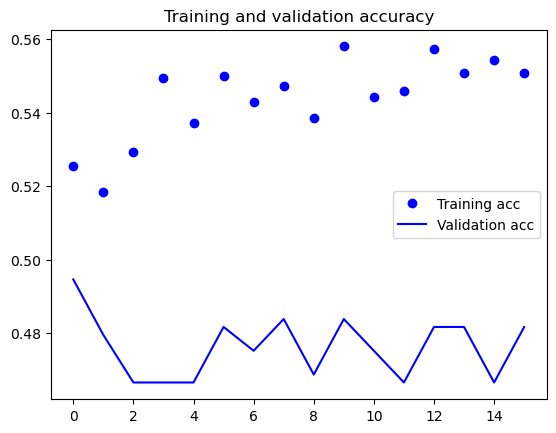

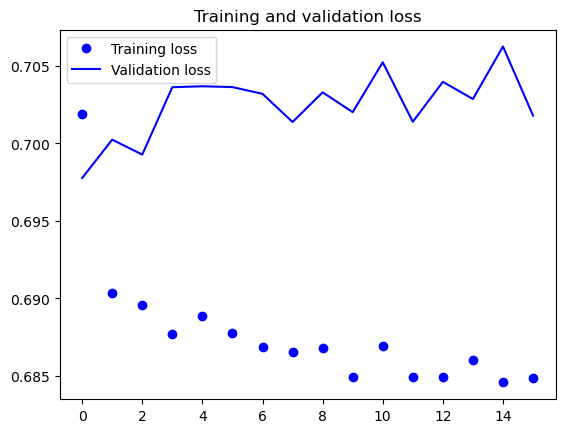

In [32]:
def paint():
    acc=history.history['acc']
    val_acc=history.history['val_acc']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(len(acc))
    plt.plot(epochs,acc,'bo',label='Training acc')
    plt.plot(epochs,val_acc,'b',label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs,loss,'bo',label='Training loss')
    plt.plot(epochs,val_loss,'b',label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    return plt
my_paint=paint()
my_paint.show()

# 混淆矩阵绘制

In [33]:
# 计算混淆矩阵（变量名用 cm，不与函数名冲突）
cm = confusion_matrix(target_test_prepared, y_pred, labels=[1, 0])

# 计算其他指标
precision = precision_score(target_test_prepared, y_pred, pos_label=1)
recall = recall_score(target_test_prepared, y_pred, pos_label=1)
f1 = f1_score(target_test_prepared, y_pred, pos_label=1)

# 打印结果
print('混淆矩阵：\n', cm)
print('查准率：', precision)
print('查全率：', recall)
print('f1-score:', f1)

混淆矩阵：
 [[162  60]
 [143  83]]
查准率： 0.5311475409836065
查全率： 0.7297297297297297
f1-score: 0.6148007590132827


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


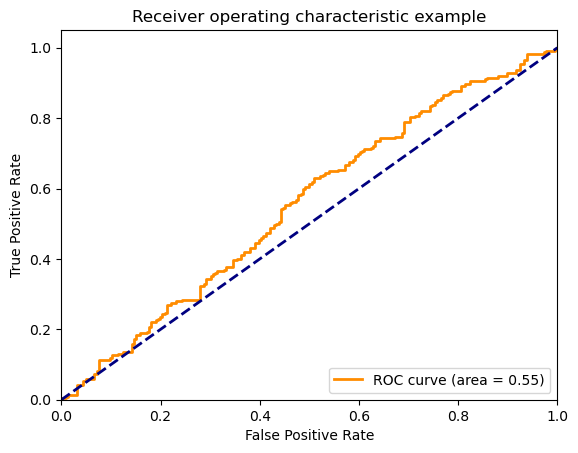

In [34]:
y_predict=final_model.predict(daily_test_prepared).reshape(test_num-daily_back).tolist()
fpr,tpr,threshold = roc_curve(target_test_prepared, y_predict) ###计算真正率和假正率
# print(fpr,tpr,threshold)
roc_auc = auc(fpr,tpr)


lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 模型结果输出保存

In [35]:
import pandas as pd
import os

# 定义当前运行得到的一行数据（以"基础LSTM"为例，实际使用时替换为当前模型的真实指标）
current_data = {
    '模型': 'SSA-LSTM（单输入）',  # 每次替换为当前模型名称
    '准确率（%）': accuracy,
    '精确率（%）': precision,
    '召回率': recall,
    'F1值': f1,
    'AUC': roc_auc,
    '胜率（%）': win_rate*100,
    '盈亏比': profit_loss_ratio,
    '夏普比率': sharpe_ratio,
    '年收益率（%）': (return_multiple-1)*100,
    '最大回撤': max_drawdown
}

# 转换为DataFrame（单行）
df_current = pd.DataFrame([current_data])

# 检查是否已存在数据文件，存在则追加，不存在则创建
file_path = 'SSA-LSTM（单输入）模型数据记录汇总.xlsx'
if os.path.exists(file_path):
    # 读取已有数据
    df_existing = pd.read_excel(file_path)
    # 追加新行
    df_updated = pd.concat([df_existing, df_current], ignore_index=True)
else:
    df_updated = df_current

# 保存更新后的数据
df_updated.to_excel(file_path, index=False)
print(f"已将数据追加到 {file_path}，当前共 {len(df_updated)} 行数据")

已将数据追加到 SSA-LSTM（单输入）模型数据记录汇总.xlsx，当前共 2 行数据
